In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

/home/lucas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
try:
    # Carregar dados
    X_scaled = np.load('../data/features/X_scaled_agregado.npy', allow_pickle=True)
    feature_names = np.load('../data/features/feature_names_agregado.npy', allow_pickle=True)
    player_names = np.load('../data/features/player_names.npy', allow_pickle=True)
    df_agregado = pd.read_csv('../data/processed_data/dados_processados_agregados.csv')
    
    print(f"✓ Dados carregados: {X_scaled.shape[0]} jogadores, {X_scaled.shape[1]} features")
except FileNotFoundError:
    print("ERRO: Arquivos .npy ou .csv não encontrados.")
    print("Por favor, execute o Notebook 1 (com a célula de salvar) primeiro.")
    raise

✓ Dados carregados: 474 jogadores, 30 features


# DB-SCAN
- Vamos fazer o mesmo processo pro k-means, iremos encontrar os parâmetros ideais: 'eps' (distãncia) e o 'min_samples'


[1] Analisando 'eps' ideal para DBSCAN (com min_samples=5)...


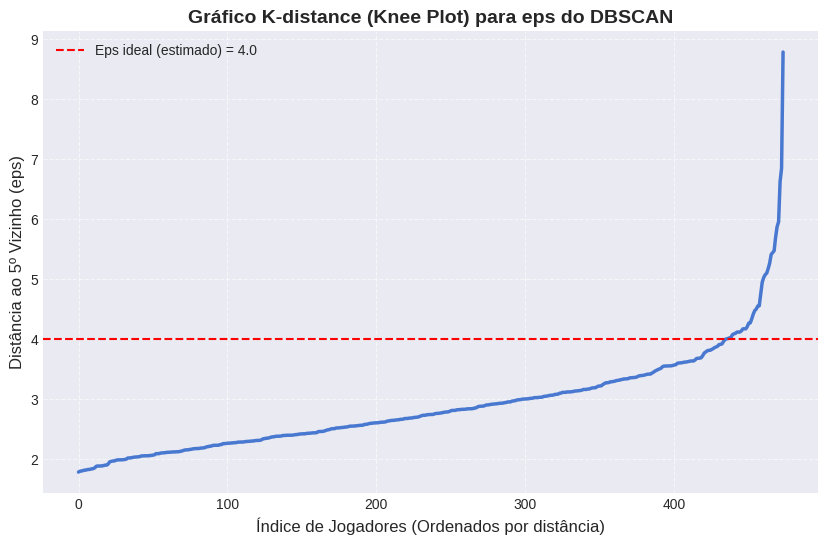

✓ Gráfico salvo: 03_dbscan_knee_plot.png
Usaremos o valor estimado: 4.0


In [4]:
MIN_SAMPLES = 5

print(f"\n[1] Analisando 'eps' ideal para DBSCAN (com min_samples={MIN_SAMPLES})...")

# Usamos NearestNeighbors para calcular a distância do k-ésimo vizinho mais próximo
# (neste caso, o 10º vizinho)
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Pegamos a distância do 10º vizinho (índice 9) e ordenamos
distances = np.sort(distances[:, MIN_SAMPLES-1], axis=0)

# Plotar o gráfico de 'Knee' (Joelho)
plt.figure(figsize=(10, 6))
plt.plot(distances, linewidth=2.5)
plt.title('Gráfico K-distance (Knee Plot) para ''eps'' do DBSCAN', fontsize=14, fontweight='bold')
plt.xlabel('Índice de Jogadores (Ordenados por distância)', fontsize=12)
plt.ylabel(f'Distância ao {MIN_SAMPLES}º Vizinho (eps)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
EPS_IDEAL_ESTIMADO = 4.0
plt.axhline(y=EPS_IDEAL_ESTIMADO, color='r', linestyle='--', label=f'Eps ideal (estimado) = {EPS_IDEAL_ESTIMADO}')
plt.legend()
plt.savefig('../images/03_dbscan_knee_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico salvo: 03_dbscan_knee_plot.png")
print(f"Usaremos o valor estimado: {EPS_IDEAL_ESTIMADO}")

In [5]:
print(f"\n[2] Aplicando DBSCAN (eps={EPS_IDEAL_ESTIMADO}, min_samples={MIN_SAMPLES})...")
dbscan = DBSCAN(eps=EPS_IDEAL_ESTIMADO, min_samples=MIN_SAMPLES)
cluster_labels = dbscan.fit_predict(X_scaled)

# Adicionar labels ao DataFrame
df_agregado['Cluster_DBSCAN'] = cluster_labels

# Analisar resultados
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters_}')
print(f'Número de outliers (ruído) encontrados: {n_noise_}')
print("\nDistribuição dos clusters (Cluster -1 = Outliers):")
print(df_agregado['Cluster_DBSCAN'].value_counts())


[2] Aplicando DBSCAN (eps=4.0, min_samples=5)...
Número de clusters encontrados: 1
Número de outliers (ruído) encontrados: 14

Distribuição dos clusters (Cluster -1 = Outliers):
Cluster_DBSCAN
 0    460
-1     14
Name: count, dtype: int64



[3] Visualizando os Clusters DBSCAN...


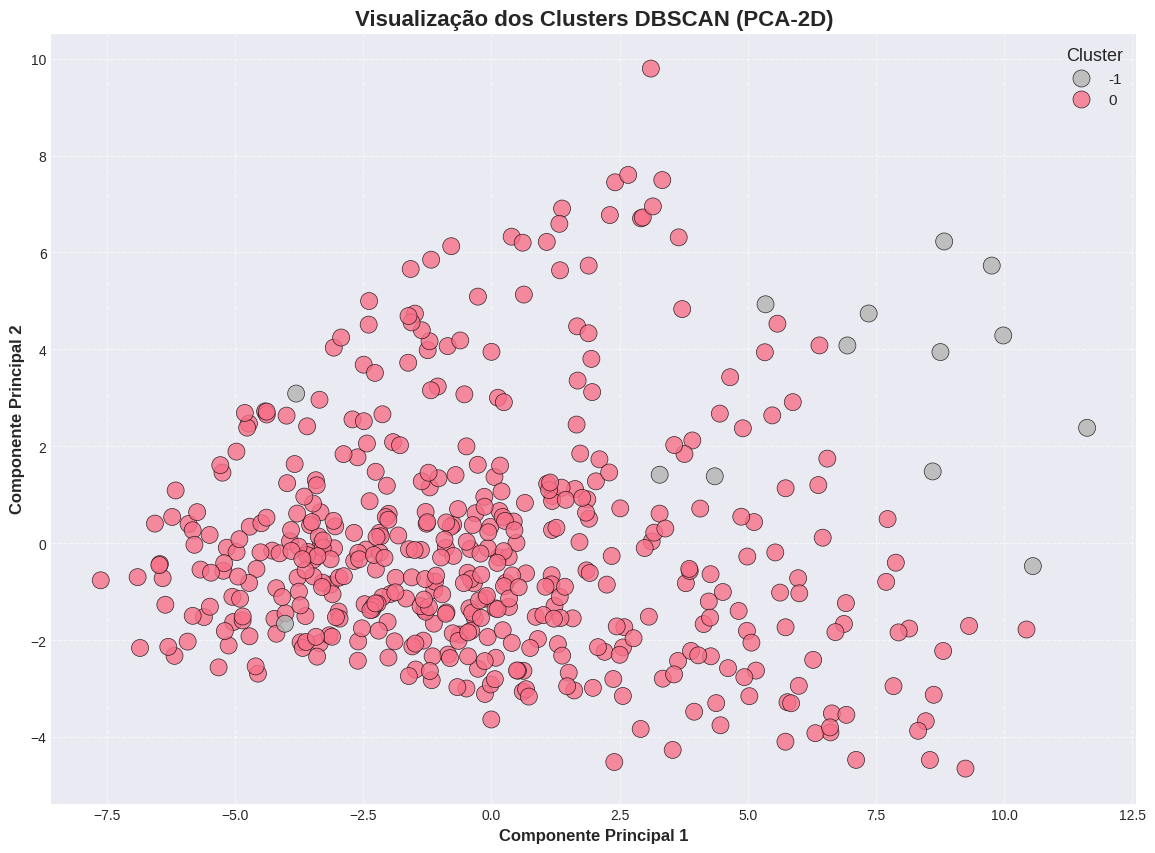

✓ Gráfico salvo: 03_dbscan_cluster_visualization.png


In [6]:
print("\n[3] Visualizando os Clusters DBSCAN...")

# Reduzir para 2D usando PCA
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# --- LÓGICA DE PLOTAGEM CORRIGIDA ---
unique_labels = sorted(set(cluster_labels))
real_cluster_labels = [label for label in unique_labels if label != -1]
n_clusters_ = len(real_cluster_labels)

# Preparar paleta de cores (corrigida)
palette = {}
if n_clusters_ > 0:
    # Gerar cores apenas para os clusters reais
    colors = sns.color_palette("husl", n_clusters_)
    # Mapear cores: clusters = coloridos
    palette = {label: colors[i] for i, label in enumerate(real_cluster_labels)}

# Adicionar a cor do ruído (-1) = cinza
palette[-1] = (0.7, 0.7, 0.7) 

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=X_pca_2d[:, 0], 
    y=X_pca_2d[:, 1],
    hue=cluster_labels,
    palette=palette,
    s=150,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

plt.title(f'Visualização dos Clusters DBSCAN (PCA-2D)', fontsize=16, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=12, fontweight='bold')
plt.ylabel('Componente Principal 2', fontsize=12, fontweight='bold')
plt.legend(title='Cluster', loc='best', fontsize=11, title_fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('03_dbscan_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico salvo: 03_dbscan_cluster_visualization.png")

In [7]:
print("\n[4] Analisando Outliers (Cluster -1)...")
df_outliers = df_agregado[df_agregado['Cluster_DBSCAN'] == -1]
df_outliers_sorted = df_outliers.sort_values(by='PTS', ascending=False)

print(f"Jogadores outliers encontrados: {len(df_outliers)}")
print("Top 5 outliers por Pontos (PTS):")
print(df_outliers_sorted[['Player', 'Tm', 'PTS', 'AST', 'TRB', 'STL', 'BLK']].head())

# Salvar outliers em CSV
df_outliers_sorted.to_csv('../data/processed_data/03_dbscan_outliers.csv', index=False)
print("\n✓ Outliers salvos em: 03_dbscan_outliers.csv")


[4] Analisando Outliers (Cluster -1)...
Jogadores outliers encontrados: 14
Top 5 outliers por Pontos (PTS):
                      Player   Tm        PTS        AST        TRB       STL  \
410  Shai Gilgeous-Alexander  OKC  32.440000   5.900000   5.220000  1.940000   
154    Giannis Antetokounmpo  MIL  31.619048   5.976190  12.333333  0.785714   
351             Nikola Jokić  DEN  29.695652  10.326087  12.695652  1.826087   
25             Anthony Davis  LAL  25.738095   3.357143  11.857143  1.285714   
230              Joel Embiid  PHI  24.600000   4.400000   8.066667  0.800000   

          BLK  
410  1.000000  
154  1.357143  
351  0.673913  
25   2.142857  
230  1.000000  

✓ Outliers salvos em: 03_dbscan_outliers.csv


In [8]:
print("\n[5] Analisando os 'Arquétipos' (Clusters 0-5)...")

# Pegar todos os clusters que NÃO são outliers (-1)
df_arquétipos = df_agregado[df_agregado['Cluster_DBSCAN'] != -1]

if len(df_arquétipos) > 0:
    print(f"Total de jogadores 'especialistas' (não-outliers) encontrados: {len(df_arquétipos)}")
    
    # Mostrar os 5 primeiros de cada cluster encontrado
    for cluster_id in sorted(df_arquétipos['Cluster_DBSCAN'].unique()):
        print(f"\n--- Perfil do Cluster {cluster_id} ---")
        df_cluster_atual = df_arquétipos[df_arquétipos['Cluster_DBSCAN'] == cluster_id]
        
        # Mostrar as médias deste cluster
        print("Médias do Cluster vs. Média Geral:")
        
        # Pegar as features do radar do Notebook 2 para comparar
        features_radar = [
            'PTS_per_Min', 'REB_per_Min', 'AST_per_Min', 
            'Defense_per_Min', '3PT_Volume_Eff', 'TS%'
        ]
        
        # Carregar a média geral (do notebook 2)
        try:
            df_perfis_kmeans = pd.read_csv('../data/processed_data/02_kmeans_perfis_clusters.csv', index_col=0)
            media_geral = df_perfis_kmeans.loc[features_radar, 'Media_Geral']
            
            perfil_cluster = df_cluster_atual[features_radar].mean()
            df_comparacao = pd.DataFrame({'Cluster': perfil_cluster, 'Media_Geral': media_geral})
            print(df_comparacao)
            
        except FileNotFoundError:
            print("Arquivo '02_kmeans_perfis_clusters.csv' não encontrado. Mostrando apenas jogadores.")

        
        print(f"\nJogadores no Cluster {cluster_id} (Top 5 por Pontos):")
        print(df_cluster_atual.sort_values(by='PTS', ascending=False)[['Player', 'Tm', 'PTS', 'AST', 'TRB']].head())

else:
    print("Nenhum cluster (além de outliers) foi encontrado com os parâmetros atuais.")


[5] Analisando os 'Arquétipos' (Clusters 0-5)...
Total de jogadores 'especialistas' (não-outliers) encontrados: 460

--- Perfil do Cluster 0 ---
Médias do Cluster vs. Média Geral:
Arquivo '02_kmeans_perfis_clusters.csv' não encontrado. Mostrando apenas jogadores.

Jogadores no Cluster 0 (Top 5 por Pontos):
              Player   Tm        PTS       AST       TRB
309      Luka Dončić  DAL  28.136364  7.818182  8.318182
299      LaMelo Ball  CHO  28.031250  7.375000  5.218750
455     Tyrese Maxey  PHI  27.840909  6.204545  3.431818
26   Anthony Edwards  MIN  27.215686  4.529412  5.784314
279     Kevin Durant  PHO  26.923077  4.179487  6.076923
